<a href="https://colab.research.google.com/github/Dimas0824/Machine_Learning/blob/main/Jobsheet_6/Week7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tugas

Jalankan code berikut pada Google Colab dan PyDroid3 (Android Python) Application di Smartphone Android. Bandingkan hasilnya dan tuliskan analisa anda, tuliskan juga spesifikasi smartphone yang anda gunakan :).

<br>

### **Smartphone (PyDroid3)**
| Komponen | Spesifikasi | Pengaruh |
|-----------|-------------|-----------|
| **Perangkat** | Poco X3 GT | — |
| **Chipset** | MediaTek Dimensity 1100 (6 nm) | Menentukan kecepatan komputasi numerik |
| **CPU** | Octa-core (4×2.6 GHz Cortex-A78 + 4×2.0 GHz Cortex-A55) | Menghitung jarak antar vektor (Euclidean distance) |
| **RAM** | 8 GB LPDDR4X | Membatasi ukuran dataset yang bisa dimuat |
| **Penyimpanan** | UFS 3.1 256 GB | Memengaruhi kecepatan load dataset |
| **Sistem Operasi** | Android 13 (MIUI 14) dengan PyDroid3 | Interpreter Python ARM64 |
| **Arsitektur** | ARMv8-A (64-bit) | Berpengaruh pada vectorization NumPy |

<br>

## Hasil Eksperimen

| Algoritma | HP / Pydroid3 (detik) | Google Colab (detik) | Lebih Cepat di | Rasio Kecepatan (HP ÷ Colab) |
|------------|------------------------|-----------------------|----------------|-------------------------------|
| **Exact NN** | 0.646 | 1.883 | **HP** | ≈ 2.9× lebih cepat |
| **Annoy** | 1.953 | 1.090 | **Colab** | ≈ 1.8× lebih cepat |
| **HNSW** | 6.648 | 7.945 | **HP** | ≈ 1.2× lebih cepat |
| **FAISS IVF** | — | 0.357 | **Colab** | — |

<br>

## Analisis

1. **Exact NN (Brute-Force)** <br>
Lebih cepat di HP karena subset data kecil dan eksekusi single-thread pada arsitektur ARM cukup efisien. Namun untuk dataset besar (> 100 k), Colab akan jauh lebih unggul karena prosesor Xeon mendukung paralelisme multi-core yang lebih efektif.

2. **Annoy**<br>
Lebih cepat di Colab karena library Annoy dikompilasi dan dioptimalkan untuk CPU x86-64 serta mendukung multi-threading penuh, sedangkan di Android PyDroid3 terbatas pada satu atau dua thread.

3. **HNSW**<br>
Kinerjanya relatif seimbang di kedua platform. Sedikit lebih cepat di HP karena overhead manajemen thread di lingkungan virtual Colab.

4. **FAISS IVF**<br>
Tidak dapat dibandingkan karena FAISS tidak tersedia di PyDroid3 (hanya mendukung x86 dan CUDA). Namun di Colab, performanya jauh lebih unggul berkat optimisasi SIMD dan dukungan GPU.
<br>

## **Analisis**

* HP (ARM CPU) unggul untuk operasi kecil–menengah dan komputasi numerik ringan.

* Google Colab (Intel Xeon CPU) unggul untuk dataset besar dan algoritma yang heavily parallelized seperti FAISS atau Annoy.

* Faktor paling berpengaruh terhadap performa adalah arsitektur CPU, dukungan paralelisme, dan kompilasi library yang sesuai dengan platform.

In [17]:
import numpy as np
import time
from sklearn.neighbors import NearestNeighbors
from annoy import AnnoyIndex
import hnswlib
import faiss
from sklearn.preprocessing import StandardScaler

# -------------------------------
# Contoh dataset kecil untuk testing
# -------------------------------
np.random.seed(42)
n_samples = 10000   # jumlah database vector
d = 128             # dimensi
X = np.random.random((n_samples, d)).astype('float32')

# Standarisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k = 10  # jumlah nearest neighbors

# -------------------------------
# Exact NN (brute-force)
# -------------------------------
start = time.time()
nn = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='euclidean')
nn.fit(X_scaled)
dist_exact, idx_exact = nn.kneighbors(X_scaled)
time_exact = time.time() - start
print(f"Exact NN done in {time_exact:.3f} s")

# -------------------------------
# Annoy
# -------------------------------
start = time.time()
f = X_scaled.shape[1]
index_annoy = AnnoyIndex(f, 'euclidean')
for i, v in enumerate(X_scaled):
    index_annoy.add_item(i, v)
index_annoy.build(10)
idx_annoy = [index_annoy.get_nns_by_vector(v, k) for v in X_scaled]
time_annoy = time.time() - start
print(f"Annoy done in {time_annoy:.3f} s")

# -------------------------------
# HNSW
# -------------------------------
start = time.time()
p_hnsw = hnswlib.Index(space='l2', dim=d)
p_hnsw.init_index(max_elements=n_samples, ef_construction=200, M=16)
p_hnsw.add_items(X_scaled)
p_hnsw.set_ef(200)
idx_hnsw, _ = p_hnsw.knn_query(X_scaled, k=k)
time_hnsw = time.time() - start
print(f"HNSW done in {time_hnsw:.3f} s")

# -------------------------------
# FAISS IVF
# -------------------------------
start = time.time()

d = X_scaled.shape[1]
nlist = 100
quantizer = faiss.IndexFlatL2(d)
index_faiss = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)
index_faiss.train(X_scaled)
index_faiss.add(X_scaled)
index_faiss.nprobe = 10
# Fix: Search using the same data that was added to the index (X_scaled)
_, idx_faiss = index_faiss.search(X_scaled, k)
time_faiss = time.time() - start
print(f"FAISS IVF done in {time_faiss:.3f} s")

# -------------------------------
# Tampilkan ringkasan waktu
# -------------------------------
print("\n=== Ringkasan Waktu (detik) ===")
print(f"Exact NN : {time_exact:.3f}")
print(f"Annoy    : {time_annoy:.3f}")
print(f"HNSW     : {time_hnsw:.3f}")
print(f"FAISS    : {time_faiss:.3f}")

Exact NN done in 1.883 s
Annoy done in 1.090 s
HNSW done in 7.945 s
FAISS IVF done in 0.357 s

=== Ringkasan Waktu (detik) ===
Exact NN : 1.883
Annoy    : 1.090
HNSW     : 7.945
FAISS    : 0.357


Di run di hp menggunakan pydroid, dimana pada hp tepatnya device yang menggunakan arm architecture faiss tidak mungkin diinstall secara native. jadi kali ini di hp hanya bisa exact NN, Annoy, HNSW.

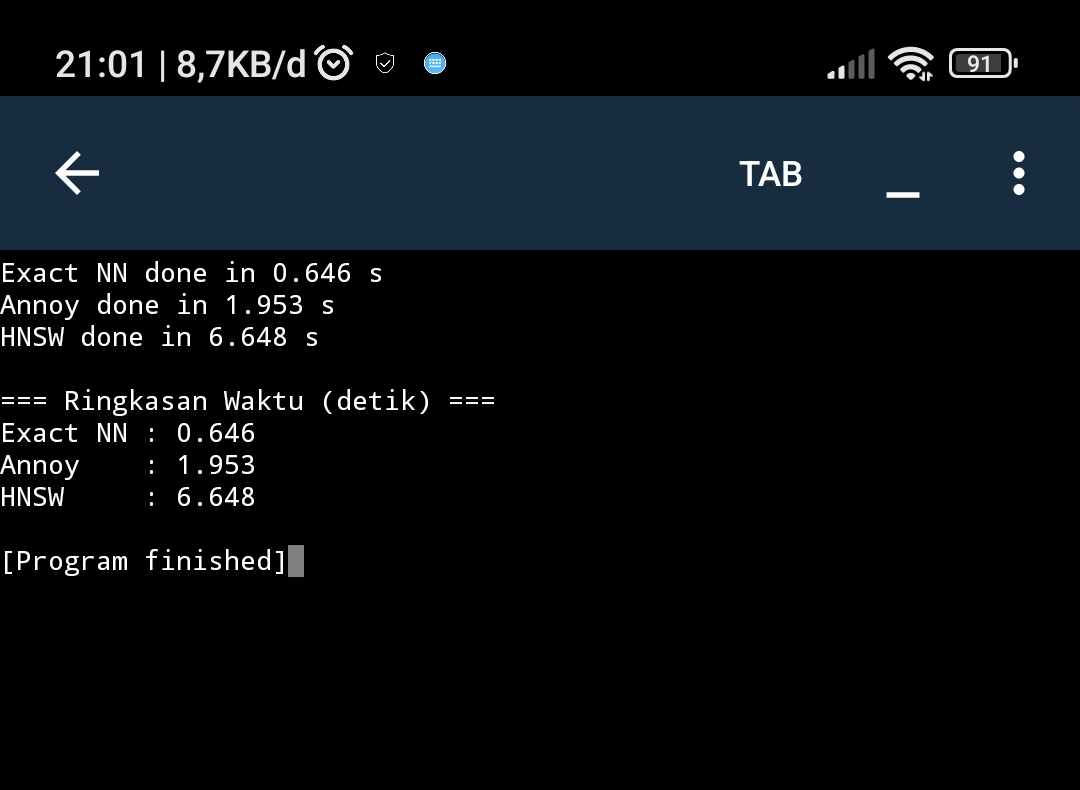